In [1]:
import matplotlib.pyplot as plt

# Data Loading

ImageView object:
  Display bands       :  [109, 192, 425]
  Interpolation       :  <default>
  RGB data limits     :
    R: [11.0, 3774.0]
    G: [14.0, 4095.0]
    B: [22.0, 4095.0]

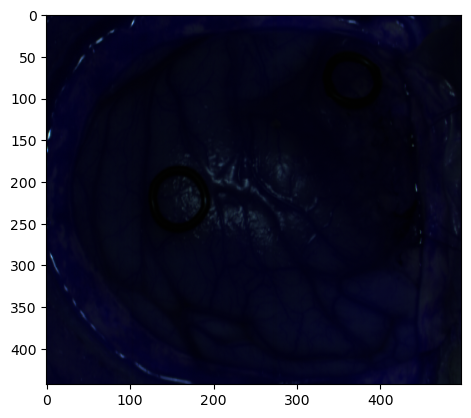

In [2]:
import spectral

# File path to the raw HDR file
raw_hdr_file = "raw.hdr"  # Update with your file path

# Load and display the raw image
raw_img = spectral.open_image(raw_hdr_file)
spectral.imshow(raw_img)


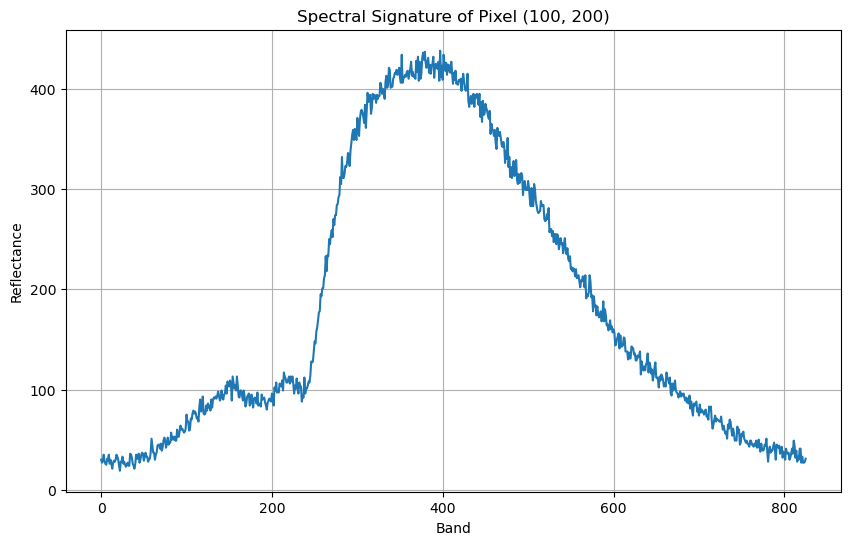

In [3]:
import matplotlib.pyplot as plt

# Select a pixel location (row, column) for which you want to plot the spectral signature
row = 100
column = 200

# Extract spectral values for the selected pixel
spectral_values = raw_img[row, column, :]

# Ensure spectral_values is a 1D array
spectral_values = spectral_values.flatten()

# Plot the spectral signature
plt.figure(figsize=(10, 6))
plt.plot(range(len(spectral_values)), spectral_values, linestyle='-')
plt.title('Spectral Signature of Pixel ({}, {})'.format(row, column))
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.grid(True)
plt.show()


In [4]:
raw_img.shape

(443, 497, 826)

# Data Calibration

In [5]:
import numpy as np
import spectral

def calibrate_hs(raw_hs, w_ref, d_ref):
    # Load raw HS, white reference, and dark reference images
    raw_hs_img = spectral.open_image(raw_hs).load()
    w_ref_img = spectral.open_image(w_ref).load()
    d_ref_img = spectral.open_image(d_ref).load()

    # Calculate normalized HS image
    calibrated_img = 100 * (raw_hs_img - d_ref_img) / (w_ref_img - d_ref_img)

    return calibrated_img

# Example usage
raw_hs_file = "raw.hdr"  # Update with your file path
w_ref_file = "whiteReference.hdr"  # Update with your file path
d_ref_file = "darkReference.hdr"  # Update with your file path

calibrated_img = calibrate_hs(raw_hs_file, w_ref_file, d_ref_file)

# Save normalized image
#output_file = "calibrated_hs_img.hdr"  # Update with your desired output file path
#spectral.envi.save_image(output_file, calibrated_img, metadata=spectral.open_image(raw_hs_file).metadata)

ImageView object:
  Display bands       :  [0, 413.0, 825]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-14.851485252380371, 97.89473724365234]
    G: [-0.18115942180156708, 416.47784423828125]
    B: [-40.0, 192.85714721679688]

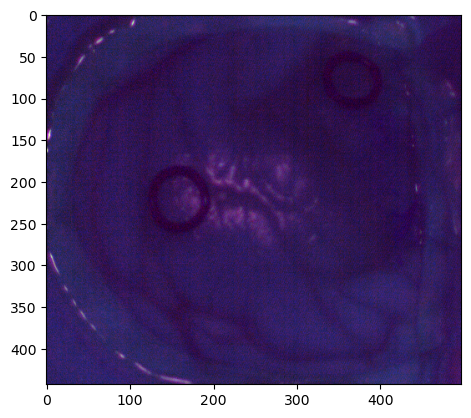

In [6]:
spectral.imshow(calibrated_img)

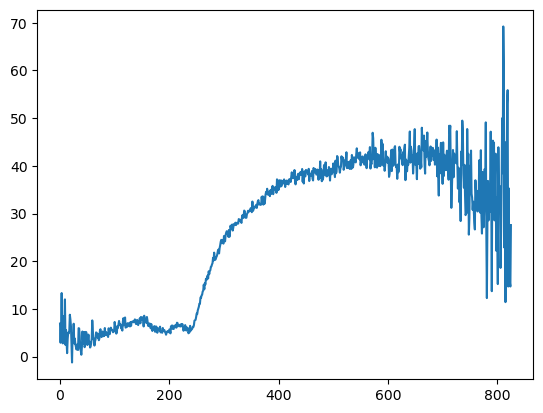

In [7]:
plt.plot(calibrated_img[100,200,:])

# Extreme Band removal

In [8]:
remove_spectral_bands_img =calibrated_img[:,:,55:700]

In [9]:
remove_spectral_bands_img.shape

(443, 497, 645)

ImageView object:
  Display bands       :  [0, 322.5, 644]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-3.278688430786133, 388.9204406738281]
    G: [0.0, 374.0128479003906]
    B: [-4.8275861740112305, 300.0]

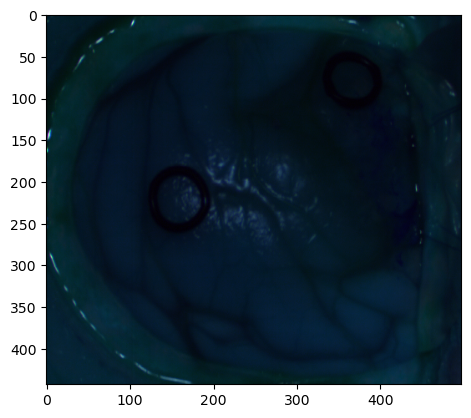

In [10]:
spectral.imshow(remove_spectral_bands_img)

# Band Averaging

In [11]:
import numpy as np

def band_averaging(remove_spectral_bands_img, num_bands_to_average):
   
    height, width, num_bands = remove_spectral_bands_img.shape
    new_num_bands = num_bands // num_bands_to_average
    averaged_image = np.zeros((height, width, new_num_bands))
    # Perform band averaging
    for i in range(0, num_bands, num_bands_to_average):
        
        end_index = min(i + num_bands_to_average, num_bands)

        averaged_band = np.mean(remove_spectral_bands_img[:, :, i:end_index], axis=2)

        averaged_image[:, :, i // num_bands_to_average] = averaged_band

    return averaged_image


num_bands_to_average = 5
averaged_image = band_averaging(remove_spectral_bands_img, num_bands_to_average)


ImageView object:
  Display bands       :  [0, 64.5, 128]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-1.0754506587982178, 403.81646728515625]
    G: [0.6158726215362549, 372.67108154296875]
    B: [0.4439231753349304, 306.7705078125]

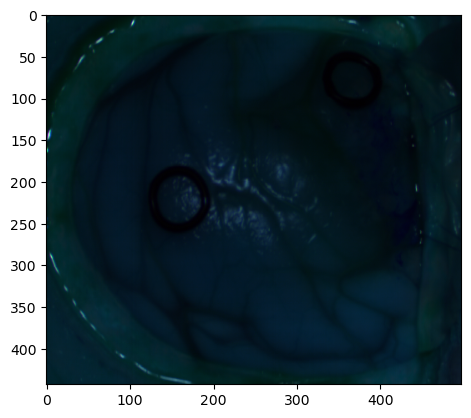

In [12]:
spectral.imshow(averaged_image)

In [13]:
decimated_hs_img = remove_spectral_bands_img[:, :, ::5]

(443, 497, 129)

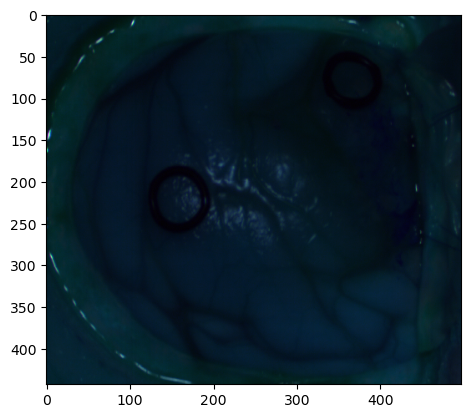

In [14]:
spectral.imshow(decimated_hs_img)
decimated_hs_img.shape

# Brightness Normalization

In [15]:
import numpy as np


Y = decimated_hs_img
num_bands = Y.shape[-1]

brightness = np.zeros_like(Y[..., 0], dtype=float)

for i in range(num_bands):
    brightness += Y[..., i]**2

brightness = np.sqrt(brightness)

Y_bc = np.zeros_like(Y, dtype=float)
for i in range(num_bands):
    Y_bc[..., i] = Y[..., i] / brightness



ImageView object:
  Display bands       :  [0, 64.5, 128]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.0689779923252273, 0.22576409648769988]
    G: [0.0, 0.1538660052259098]
    B: [-0.18725073553772567, 0.5105713337372193]

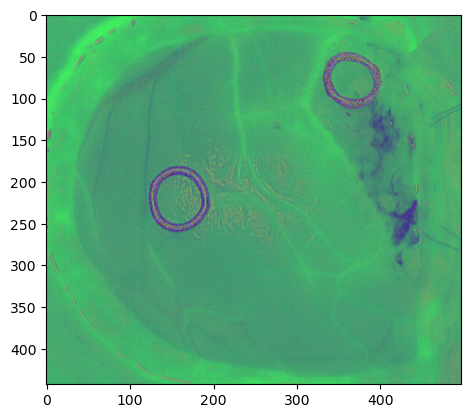

In [16]:
spectral.imshow(Y_bc)

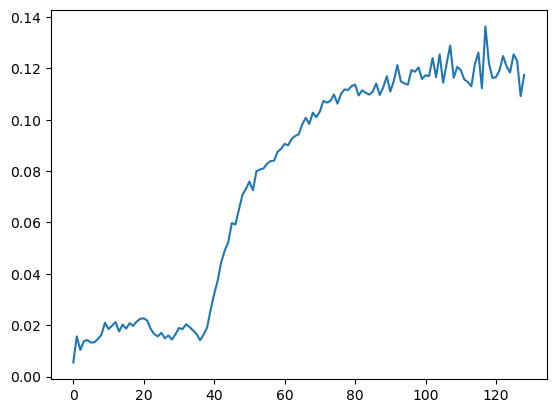

In [17]:
plt.plot(Y_bc[100,200,:])

# Noise Filtering

In [18]:
from scipy.ndimage import gaussian_filter


sigma = 1  
filtered_image = gaussian_filter(Y_bc, sigma=sigma)



ImageView object:
  Display bands       :  [0, 64.5, 128]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0002883729998690921, 0.09651991498530732]
    G: [0.028771646497873237, 0.14644279287879058]
    B: [0.07084075055033606, 0.2569615945806214]

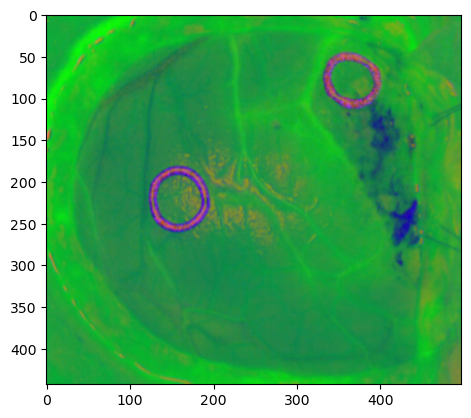

In [19]:
spectral.imshow(filtered_image)

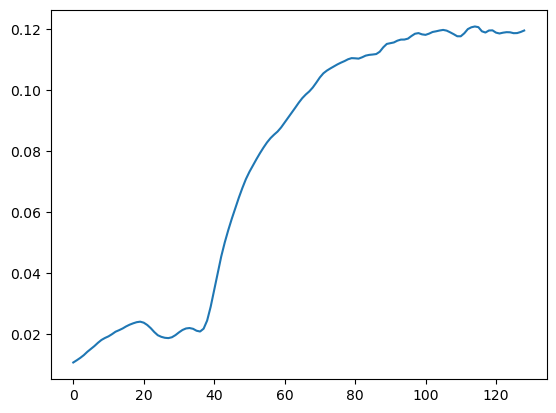

In [20]:
plt.plot(filtered_image[100,200,:])

# Data Normalization

In [21]:
import numpy as np

def min_max_normalization(filtered_image):
   
    normalized_img = np.zeros_like(filtered_image, dtype=float)

    # Iterate over each pixel in the image
    for i in range(filtered_image.shape[0]):
        for j in range(filtered_image.shape[1]):
            for k in range(filtered_image.shape[2]):  
                pixel_value = filtered_image[i, j, k]

                
                min_value = np.min(filtered_image[i, j, :])
                max_value = np.max(filtered_image[i, j, :])
                normalized_value = (pixel_value - min_value) / (max_value - min_value)

                normalized_img[i, j, k] = normalized_value

    return normalized_img

In [22]:
normal_img = min_max_normalization(filtered_image)

ImageView object:
  Display bands       :  [0, 64.5, 128]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.7288662916607681]
    G: [0.054783241594256335, 0.997508244111821]
    B: [0.30439742109952367, 1.0]

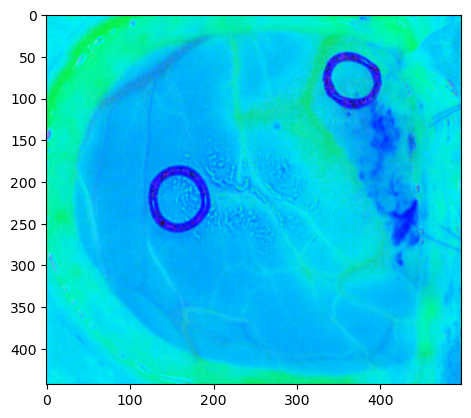

In [23]:
spectral.imshow(normal_img)

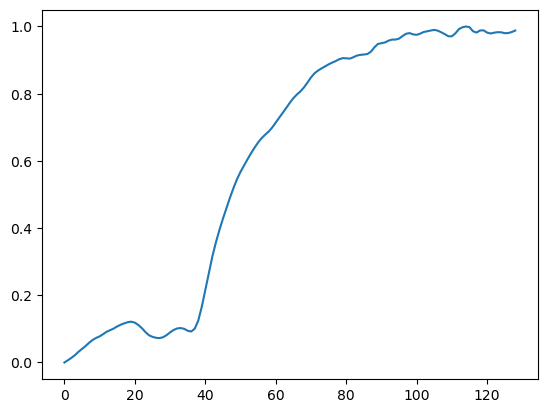

In [24]:
plt.plot(normal_img[100,200,:])

In [25]:
output_file = "normal_img.hdr"  
spectral.envi.save_image(output_file, normal_img, metadata=spectral.open_image(raw_hs_file).metadata)

In [26]:
from scipy.io import savemat

savemat('normal_img.mat', {'normal_img': normal_img})


# Unsupervised Clustering

In [27]:
from sklearn.cluster import KMeans

def apply_kmeans_clustering(normal_img, n_clusters):

  data_reshaped = normal_img.reshape((normal_img.shape[0] * normal_img.shape[1],normal_img.shape[2]))

  kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # Set random state for reproducibility
  kmeans.fit(data_reshaped)
  cluster_labels = kmeans.labels_

  clustered_img = cluster_labels.reshape(normal_img.shape[0], normal_img.shape[1])

  return clustered_img

n_clusters = 5

clustered_img = apply_kmeans_clustering(normal_img, n_clusters)


ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 4.0]
    G: [0.0, 4.0]
    B: [0.0, 4.0]

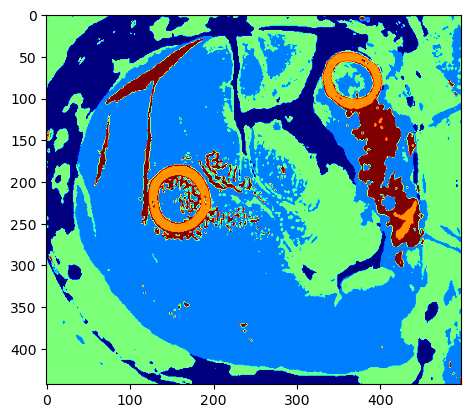

In [28]:
spectral.imshow(clustered_img,cmap='jet')

# Brightness Normalization(without Decimation)

In [29]:
import numpy as np


Z = remove_spectral_bands_img
num_bands = Z.shape[-1]
brightness = np.zeros_like(Z[..., 0], dtype=float)
for i in range(num_bands):
    brightness += Z[..., i]**2
brightness = np.sqrt(brightness)

Z_bc = np.zeros_like(Z, dtype=float)
for i in range(num_bands):
    Z_bc[..., i] = Z[..., i] / brightness



ImageView object:
  Display bands       :  [0, 322.5, 644]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.030398017078661615, 0.09163384525689054]
    G: [0.0, 0.06928435015601891]
    B: [-0.0800227608910979, 0.24357095435112944]

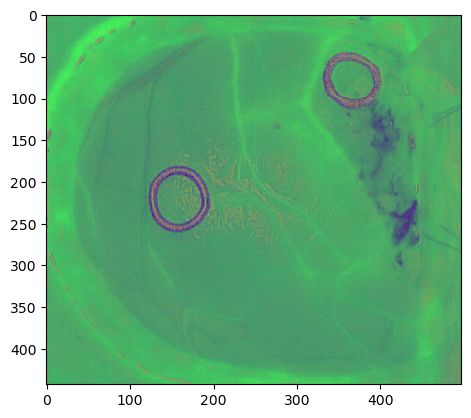

In [30]:
spectral.imshow(Z_bc)

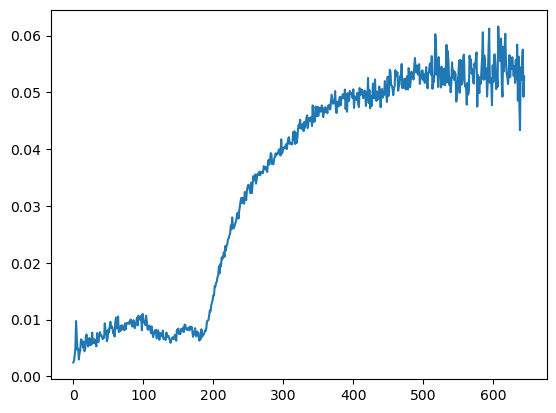

In [31]:
plt.plot(Z_bc[100,200,:])

# Noise Filtering

In [32]:
from scipy.ndimage import gaussian_filter

sigma = 1 
filter_image = gaussian_filter(Z_bc, sigma=sigma)


ImageView object:
  Display bands       :  [0, 322.5, 644]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0002754073680157113, 0.04388233554874079]
    G: [0.013363146927539349, 0.06546131270633487]
    B: [0.03184706166840881, 0.11431815567466805]

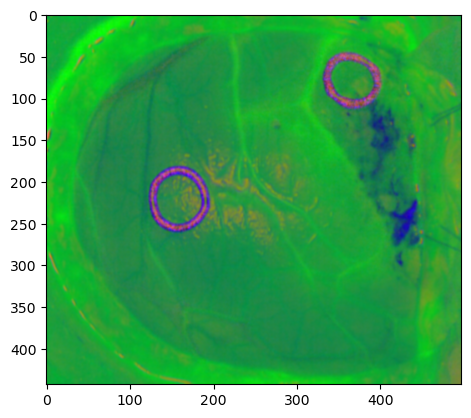

In [33]:
spectral.imshow(filter_image)

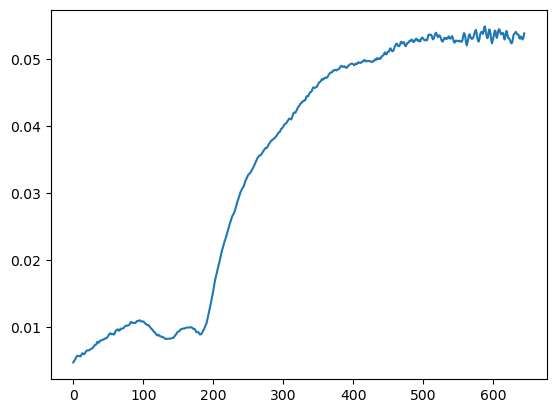

In [34]:
plt.plot(filter_image[100,200,:])

# Data Normalization (without Decimation)

In [35]:
import numpy as np

def min_max_normal(filter_image):
    normalized_img = np.zeros_like(filter_image, dtype=float)
    for i in range(filter_image.shape[0]):
        for j in range(filter_image.shape[1]):
            for k in range(filter_image.shape[2]): 
                pixel_value = filter_image[i, j, k]
                min_value = np.min(filter_image[i, j, :])
                max_value = np.max(filter_image[i, j, :])
                normalized_value = (pixel_value - min_value) / (max_value - min_value)
                normalized_img[i, j, k] = normalized_value

    return normalized_img

In [ ]:
normal_bands_img = min_max_normal(filter_image)

In [ ]:
spectral.imshow(normal_bands_img)

In [ ]:
plt.plot(normal_bands_img[100,200,:])

# One band representation(t-SNE)

In [ ]:

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

h, w, bands = normal_bands_img.shape
flattened_img = np.reshape(normal_bands_img, (h * w, bands))
tsne = TSNE(n_components=1, random_state=42)
embedded_img = tsne.fit_transform(flattened_img)

print("Embedded Image Shape:", embedded_img.shape)

# Visualize the first t-SNE component
#plt.figure(figsize=(10, 6))
#plt.plot(embedded_img)
#plt.xlabel("Data Point")
#plt.ylabel("t-SNE Component 1")
#plt.title("Visualization of t-SNE Component 1")
#plt.grid(True)
#plt.show()

In [ ]:
embedded_img = embedded_img.reshape((445, 498)) 
plt.figure(figsize=(10, 6))
plt.imshow(embedded_img, cmap='jet')
plt.colorbar(label='t-SNE Component 1')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Visualization of t-SNE Component 1 as an Image')
plt.show()


In [ ]:
spectral.imshow(embedded_img, cmap='gray')

In [ ]:
embedded_img.shape

In [ ]:
np.unique(embedded_img)

# KNN filtering(Not needed)

In [ ]:
spectral.imshow(filtered_embedded_img, cmap='nipy_spectral')

# Supervised Classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import spectral

ground_truth = spectral.open_image("gtMap.hdr").load()
X = normal_img.reshape(-1, normal_img.shape[-1])
y = ground_truth.flatten()
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X, y)
predict_label = rf_classifier.predict(X)
predict_label = predict_label.reshape(normal_img.shape[:-1])

plt.imshow(predict_label, cmap='jet')  # Use 'jet' colormap for visualization
plt.colorbar(label='Class')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Normal Image with Assigned Class Labels')
plt.show()


In [ ]:
spectral.imshow(predict_label, cmap='jet')
predict_label.shape


# KNN Filtering

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def knn_filter(embedded_img, predict_label, neighborhood_size):
    filtered_img = np.zeros_like(embedded_img)
    knn_model = NearestNeighbors(n_neighbors=1)
    h, w = embedded_img.shape
    for i in range(h):
        for j in range(w):
            current_label = predict_label[i, j]
            i_start = max(0, i - neighborhood_size // 2)
            i_end = min(h, i + neighborhood_size // 2 + 1)
            j_start = max(0, j - neighborhood_size // 2)
            j_end = min(w, j + neighborhood_size // 2 + 1)
            neighborhood = embedded_img[i_start:i_end, j_start:j_end]
            flattened_neighborhood = neighborhood.flatten().reshape(-1, 1)
            knn_model.fit(flattened_neighborhood)
            _, nearest_neighbor_idx = knn_model.kneighbors(embedded_img[i, j].reshape(1, -1))
            filtered_img[i, j] = flattened_neighborhood[nearest_neighbor_idx]

    return filtered_img

neighborhood_size = 50  # Adjust as needed
filter_embed_img = knn_filter(embedded_img, predict_label, neighborhood_size)


In [ ]:
spectral.imshow(filter_embed_img,cmap='nipy_spectral')


In [ ]:
spectral.imshow(embedded_img,cmap='jet')

# Majority Voting

In [ ]:
import numpy as np
import spectral
from scipy.stats import mode

tmd_map = np.zeros_like(clustered_img)
for i in range(clustered_img.shape[0]):
    for j in range(clustered_img.shape[1]):
        clustered_label = clustered_img[i, j]
        filter_embed_img_label = filter_embed_img[i, j]
        combined_label = mode([clustered_label, filter_embed_img_label])[0][0]
        tmd_map[i, j] = combined_label

# Save the TMD map
#output_tmd_file = "tmd_map.hdr"  # Update with your desired output file path
#spectral.envi.save_image(output_tmd_file, tmd_map.astype(np.uint8), metadata=clustered_img.metadata)

In [ ]:
spectral.imshow(tmd_map, cmap='jet')

# One band representation

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def perform_pca(normal_bands_img, n_components):
    h, w, bands = normal_bands_img.shape
    flattened_img = np.reshape(normal_bands_img, (h * w, bands))
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(flattened_img)
    pca_img = np.reshape(pca_result, (h, w, n_components))

    return pca_img
n_components = 1  # Retain only one principal component
pca_img = perform_pca(normal_bands_img, n_components)

In [ ]:
spectral.imshow(pca_img,cmap='jet')
pca_img.shape

In [ ]:
spectral.imshow(pca_img,cmap='gray')
pca_img.shape

In [ ]:
pca_img1 = np.squeeze(pca_img)

In [ ]:
pca_img1.shape

# KNN filtering

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def knn_filter(pca_img1, predict_label, neighborhood_size):
    filtered_img = np.zeros_like(pca_img1)
    knn_model = NearestNeighbors(n_neighbors=1)
    h, w = pca_img1.shape
    for i in range(h):
        for j in range(w):
            current_label = predict_label[i, j]
            i_start = max(0, i - neighborhood_size // 2)
            i_end = min(h, i + neighborhood_size // 2 + 1)
            j_start = max(0, j - neighborhood_size // 2)
            j_end = min(w, j + neighborhood_size // 2 + 1)
            neighborhood = pca_img1[i_start:i_end, j_start:j_end]
            flattened_neighborhood = neighborhood.flatten().reshape(-1, 1)
            knn_model.fit(flattened_neighborhood)
            _, nearest_neighbor_idx = knn_model.kneighbors(pca_img1[i, j].reshape(1, -1))
            filtered_img[i, j] = flattened_neighborhood[nearest_neighbor_idx]

    return filtered_img
neighborhood_size = 50  # Adjust as needed
filter_pca_img = knn_filter(pca_img1, predict_label, neighborhood_size)


In [ ]:
spectral.imshow(filter_pca_img,cmap='jet')

# Majority Voting

In [ ]:
import numpy as np
import spectral
from scipy.stats import mode
tmd_map1 = np.zeros_like(clustered_img)
for i in range(clustered_img.shape[0]):
    for j in range(clustered_img.shape[1]):
        clustered_label = clustered_img[i, j]
        filter_pca_img_label = filter_pca_img[i, j]
        combined_label = mode([clustered_label, filter_pca_img_label])[0][0]
        tmd_map1[i, j] = combined_label

# Save the TMD map
#output_tmd_file = "tmd_map.hdr"  # Update with your desired output file path
#spectral.envi.save_image(output_tmd_file, tmd_map.astype(np.uint8), metadata=clustered_img.metadata)

In [ ]:
spectral.imshow(tmd_map1,cmap='jet')

In [ ]:
tmd_map1.shape

In [ ]:
spectral.imshow(ground_truth,cmap='nipy_spectral')

In [ ]:
ground_truth.shape

In [ ]:
ground_truth = np.squeeze(ground_truth)

In [ ]:
ground_truth.shape

# Evaluation and validation

In [ ]:
pip install scikit-image


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
ssim_score = ssim(tmd_map1, ground_truth)

# Calculate MSE
mse_score = mean_squared_error(tmd_map1, ground_truth)

print("SSIM:", ssim_score)
print("MSE:", mse_score)
